#### put dataset in google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !unzip "/content/drive/MyDrive/2021_Olympics.zip" -d "/content/drive/MyDrive"

#### import libraries

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import pylab as p
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

#### read excel files of dataset

In [4]:
file_names = ["Athletes.xlsx","Coaches.xlsx","EntriesGender.xlsx", "Medals.xlsx","Teams.xlsx"]
path_to_dataset = "/content/drive/MyDrive/2021_Olympics/"
athletes_df = pd.read_excel(path_to_dataset+file_names[0])
coaches_df = pd.read_excel(path_to_dataset+file_names[1])
entries_gender_df = pd.read_excel(path_to_dataset+file_names[2])
medals_df = pd.read_excel(path_to_dataset+file_names[3])
teams_df = pd.read_excel(path_to_dataset+file_names[4])

In [5]:
athletes_df.head(), coaches_df.head(), entries_gender_df.head(), medals_df.head(), teams_df.head()

(                Name     NOC           Discipline
 0    AALERUD Katrine  Norway         Cycling Road
 1        ABAD Nestor   Spain  Artistic Gymnastics
 2  ABAGNALE Giovanni   Italy               Rowing
 3     ABALDE Alberto   Spain           Basketball
 4      ABALDE Tamara   Spain           Basketball,
               Name            NOC  Discipline Event
 0  ABDELMAGID Wael          Egypt    Football   NaN
 1        ABE Junya          Japan  Volleyball   NaN
 2    ABE Katsuhiko          Japan  Basketball   NaN
 3     ADAMA Cherif  Côte d'Ivoire    Football   NaN
 4       AGEBA Yuya          Japan  Volleyball   NaN,
             Discipline  Female  Male  Total
 0       3x3 Basketball      32    32     64
 1              Archery      64    64    128
 2  Artistic Gymnastics      98    98    196
 3    Artistic Swimming     105     0    105
 4            Athletics     969  1072   2041,
    Rank                    Team/NOC  Gold  Silver  Bronze  Total  Rank by Total
 0     1    United Sta

In [6]:
athletes_df.shape, coaches_df.shape, entries_gender_df.shape, medals_df.shape, teams_df.shape

((11085, 3), (394, 4), (46, 4), (93, 7), (743, 4))

#### convert nominal values to numeric values

In [7]:
def convert_nominal_to_numeric(dataframe):
  for column_name in dataframe.keys():
    if dataframe[column_name].dtype == np.object:
      dataframe[column_name+"_numeric"] = pd.factorize(dataframe[column_name])[0]
      # print("value count of column '"+column_name+"': ", dataframe[column_name].value_counts())
      # print("value count of column '"+column_name+"_numeric': ", dataframe[column_name+"_numeric"].value_counts())
  return dataframe

In [8]:
athletes_df = convert_nominal_to_numeric(athletes_df)
coaches_df = convert_nominal_to_numeric(coaches_df)
entries_gender_df = convert_nominal_to_numeric(entries_gender_df)
medals_df = convert_nominal_to_numeric(medals_df)
teams_df = convert_nominal_to_numeric(teams_df)

In [9]:
def count_of_unique_values(dataframe):
  print("column_name", "number_of_unique_values")
  for column_name in dataframe.keys():
    print(column_name ,len(dataframe[column_name].unique()))

In [10]:
count_of_unique_values(athletes_df)
athletes_df.head()

column_name number_of_unique_values
Name 11062
NOC 206
Discipline 46
Name_numeric 11062
NOC_numeric 206
Discipline_numeric 46


,Name,NOC,Discipline,Name_numeric,NOC_numeric,Discipline_numeric
0,AALERUD Katrine,Norway,Cycling Road,0,0,0
1,ABAD Nestor,Spain,Artistic Gymnastics,1,1,1
2,ABAGNALE Giovanni,Italy,Rowing,2,2,2
3,ABALDE Alberto,Spain,Basketball,3,1,3
4,ABALDE Tamara,Spain,Basketball,4,1,3


In [11]:
count_of_unique_values(coaches_df)
coaches_df.head()

column_name number_of_unique_values
Name 381
NOC 61
Discipline 9
Event 7
Name_numeric 381
NOC_numeric 61
Discipline_numeric 9
Event_numeric 7


,Name,NOC,Discipline,Event,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric
0,ABDELMAGID Wael,Egypt,Football,NaN,0,0,0,-1
1,ABE Junya,Japan,Volleyball,NaN,1,1,1,-1
2,ABE Katsuhiko,Japan,Basketball,NaN,2,1,2,-1
3,ADAMA Cherif,Côte d'Ivoire,Football,NaN,3,2,0,-1
4,AGEBA Yuya,Japan,Volleyball,NaN,4,1,1,-1


In [12]:
count_of_unique_values(entries_gender_df)
entries_gender_df.head()

column_name number_of_unique_values
Discipline 46
Female 38
Male 41
Total 41
Discipline_numeric 46


,Discipline,Female,Male,Total,Discipline_numeric
0,3x3 Basketball,32,32,64,0
1,Archery,64,64,128,1
2,Artistic Gymnastics,98,98,196,2
3,Artistic Swimming,105,0,105,3
4,Athletics,969,1072,2041,4


In [13]:
count_of_unique_values(medals_df)
medals_df.head()

column_name number_of_unique_values
Rank 67
Team/NOC 93
Gold 14
Silver 17
Bronze 21
Total 30
Rank by Total 30
Team/NOC_numeric 93


,Rank,Team/NOC,Gold,Silver,Bronze,Total,Rank by Total,Team/NOC_numeric
0,1,United States of America,39,41,33,113,1,0
1,2,People's Republic of China,38,32,18,88,2,1
2,3,Japan,27,14,17,58,5,2
3,4,Great Britain,22,21,22,65,4,3
4,5,ROC,20,28,23,71,3,4


In [14]:
count_of_unique_values(teams_df)
teams_df.head()

column_name number_of_unique_values
Name 146
Discipline 20
NOC 84
Event 36
Name_numeric 146
Discipline_numeric 20
NOC_numeric 84
Event_numeric 36


,Name,Discipline,NOC,Event,Name_numeric,Discipline_numeric,NOC_numeric,Event_numeric
0,Belgium,3x3 Basketball,Belgium,Men,0,0,0,0
1,China,3x3 Basketball,People's Republic of China,Men,1,0,1,0
2,China,3x3 Basketball,People's Republic of China,Women,1,0,1,1
3,France,3x3 Basketball,France,Women,2,0,2,1
4,Italy,3x3 Basketball,Italy,Women,3,0,3,1


## 1. Dataset Analysis

### 1.1 information of attributes

In [15]:
def attributes_information(dataframe):
  info = dict()
  index = 1
  for column_name in dataframe.keys():
    info["column"+str(index)+"_name"] = column_name
    info["column"+str(index)+"_dtype"] = dataframe[column_name].dtype
    if info["column"+str(index)+"_dtype"] == np.object:
      info["column"+str(index)+"_range"] = dataframe[column_name].unique()
    elif info["column"+str(index)+"_dtype"] == np.int or info["column"+str(index)+"_dtype"] == np.float:
      info["column"+str(index)+"_range"] = [ dataframe[column_name].min(), dataframe[column_name].max()]
      info["column"+str(index)+"_mean"] = dataframe[column_name].mean()
      info["column"+str(index)+"_median"] = dataframe[column_name].median()
      info["column"+str(index)+"_mode"] = dataframe[column_name].mode()
      info["column"+str(index)+"_min"] = dataframe[column_name].min()
      info["column"+str(index)+"_max"] = dataframe[column_name].max()

    index += 1
  return info

In [16]:
athletes_attrs_info = attributes_information(athletes_df)
coaches_info = attributes_information(coaches_df)
entries_gender_attrs_info = attributes_information(entries_gender_df)
medals_attrs_info = attributes_information(medals_df)
teams_attrs_info = attributes_information(teams_df)

In [17]:
athletes_attrs_info

{'column1_dtype': dtype('O'),
 'column1_name': 'Name',
 'column1_range': array(['AALERUD Katrine', 'ABAD Nestor', 'ABAGNALE Giovanni', ...,
        'ZYKOVA Yulia', 'ZYUZINA Ekaterina', 'ZYZANSKA Sylwia'],
       dtype=object),
 'column2_dtype': dtype('O'),
 'column2_name': 'NOC',
 'column2_range': array(['Norway', 'Spain', 'Italy', 'France', 'Chile', 'Sudan',
        'Islamic Republic of Iran', 'Azerbaijan', 'Netherlands',
        'Australia', 'United States of America', 'Qatar', 'Egypt',
        'Belgium', 'Malaysia', 'Singapore', 'Maldives', 'Saudi Arabia',
        'Germany', 'Uzbekistan', 'Indonesia', 'Kazakhstan', 'Bahrain',
        'Japan', 'Ethiopia', 'Canada', 'Malta', 'Sri Lanka', 'Morocco',
        'Austria', 'Mauritania', 'ROC', 'Libya', 'Nauru', 'Switzerland',
        'South Africa', 'Guyana', 'Georgia', 'Portugal', 'Jordan',
        'Palestine', 'India', 'Cyprus', 'Nigeria', 'Tunisia', 'Mexico',
        'Colombia', 'El Salvador', 'Romania', 'Poland',
        'Federated Stat

### 1.2 show skewness of numeric data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a70f40ad0>,
      dtype=object)

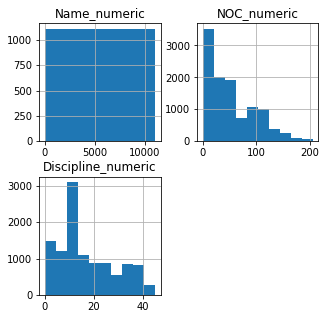

In [18]:
athletes_df.hist(figsize=(5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a70d1af90>,
      dtype=object)

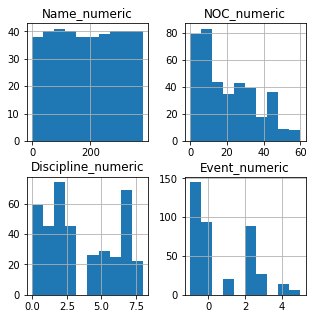

In [19]:
coaches_df.hist(figsize=(5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a704c5ed0>,
      dtype=object)

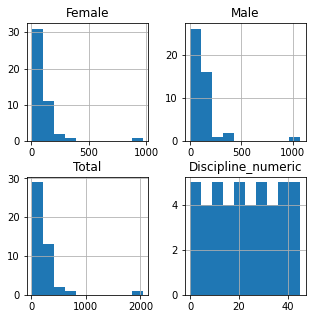

In [20]:
entries_gender_df.hist(figsize=(5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a7054d550>,
      dtype=object)

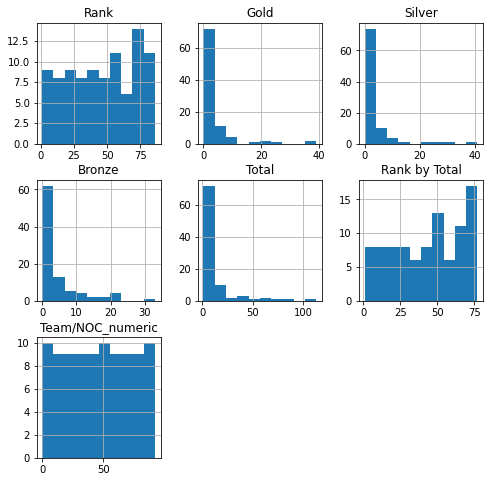

In [21]:
medals_df.hist(figsize=(8,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a6fee8510>,
      dtype=object)

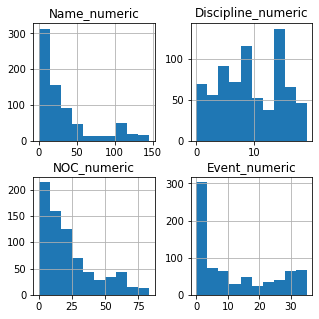

In [22]:
teams_df.hist(figsize=(5,5))

### 1.3 validity and correctness and completeness

##### help link: https://www.analyticsvidhya.com/blog/2021/05/dealing-with-missing-values-in-python-a-complete-guide/

In [23]:
# athletes_df has no column with numeric values so we need to check null or none values
# athletes_df.loc[athletes_df["Name"].isnull() | athletes_df["NOC"].isnull() | athletes_df["Discipline"].isnull() |
#                 athletes_df["Name"].isna() | athletes_df["NOC"].isna() | athletes_df["Discipline"].isna()]
athletes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11085 entries, 0 to 11084
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Name                11085 non-null  object
 1   NOC                 11085 non-null  object
 2   Discipline          11085 non-null  object
 3   Name_numeric        11085 non-null  int64 
 4   NOC_numeric         11085 non-null  int64 
 5   Discipline_numeric  11085 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 519.7+ KB


In [24]:
# coaches_df.loc[coaches_df["Name"].isna() | coaches_df["NOC"].isna() | coaches_df["Discipline"].isna() |
#                coaches_df["Event"].isna()]
coaches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Name                394 non-null    object
 1   NOC                 394 non-null    object
 2   Discipline          394 non-null    object
 3   Event               249 non-null    object
 4   Name_numeric        394 non-null    int64 
 5   NOC_numeric         394 non-null    int64 
 6   Discipline_numeric  394 non-null    int64 
 7   Event_numeric       394 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 24.8+ KB


In [25]:
# entries_gender_df.loc[(entries_gender_df["Female"] < 0) | (entries_gender_df["Male"] < 0) | 
#                       (entries_gender_df["Total"] < 0) | entries_gender_df["Discipline"].isna() |
#                       entries_gender_df["Female"].isna() | entries_gender_df["Male"].isna() |
#                       entries_gender_df["Total"].isna()]
entries_gender_df.info()
print("data that is not in correct range:")
entries_gender_df.loc[(entries_gender_df["Female"] < 0) | (entries_gender_df["Male"] < 0) | (entries_gender_df["Total"] < 0) | 
                      ((entries_gender_df["Female"]+entries_gender_df["Male"]) != entries_gender_df["Total"])]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Discipline          46 non-null     object
 1   Female              46 non-null     int64 
 2   Male                46 non-null     int64 
 3   Total               46 non-null     int64 
 4   Discipline_numeric  46 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.9+ KB
data that is not in correct range:


,Discipline,Female,Male,Total,Discipline_numeric


In [26]:
# medals_df.loc[(medals_df["Rank"] < 1) | (medals_df["Gold"] < 0) | (medals_df["Silver"] < 0) | 
#               (medals_df["Bronze"] < 0) | (medals_df["Total"] < 0) | 
#               (medals_df["Rank by Total"] < 0) | medals_df["Rank"].isna() | medals_df["Team/NOC"].isna() |
#               medals_df["Gold"].isna() | medals_df["Silver"].isna() | medals_df["Bronze"].isna() |
#               medals_df["Total"].isna() | medals_df["Rank by Total"].isna()]
medals_df.info()
print("data that is not in correct range:")
medals_df.loc[(medals_df["Rank"] < 1) | (medals_df["Gold"] < 0) | (medals_df["Silver"] < 0) |
              (medals_df["Bronze"] < 0) | (medals_df["Total"] < 0)| 
              ((medals_df["Gold"]+medals_df["Silver"]+medals_df["Bronze"]) != medals_df["Total"]) | 
              (medals_df["Rank by Total"] < 0)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Rank              93 non-null     int64 
 1   Team/NOC          93 non-null     object
 2   Gold              93 non-null     int64 
 3   Silver            93 non-null     int64 
 4   Bronze            93 non-null     int64 
 5   Total             93 non-null     int64 
 6   Rank by Total     93 non-null     int64 
 7   Team/NOC_numeric  93 non-null     int64 
dtypes: int64(7), object(1)
memory usage: 5.9+ KB
data that is not in correct range:


,Rank,Team/NOC,Gold,Silver,Bronze,Total,Rank by Total,Team/NOC_numeric


In [27]:
# teams_df[teams_df["Name"].isna() | teams_df["Discipline"].isna() | teams_df["NOC"].isna() | teams_df["Event"].isna()]
teams_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Name                743 non-null    object
 1   Discipline          743 non-null    object
 2   NOC                 743 non-null    object
 3   Event               743 non-null    object
 4   Name_numeric        743 non-null    int64 
 5   Discipline_numeric  743 non-null    int64 
 6   NOC_numeric         743 non-null    int64 
 7   Event_numeric       743 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 46.6+ KB


### 1.4 show histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a6fd0e710>,
      dtype=object)

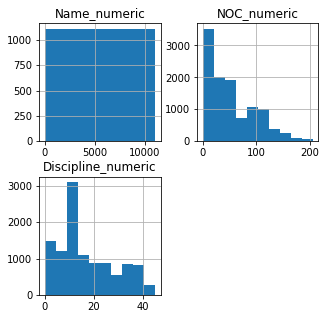

In [28]:
athletes_df.hist(figsize=(5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a6ecbc710>,
      dtype=object)

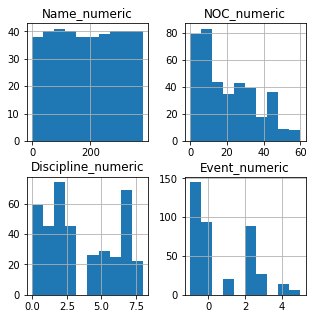

In [29]:
coaches_df.hist(figsize=(5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a70db7e10>,
      dtype=object)

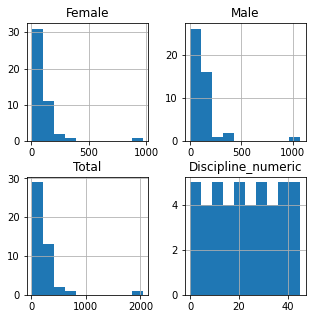

In [30]:
entries_gender_df.hist(figsize=(5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a6ea2ea50>,
      dtype=object)

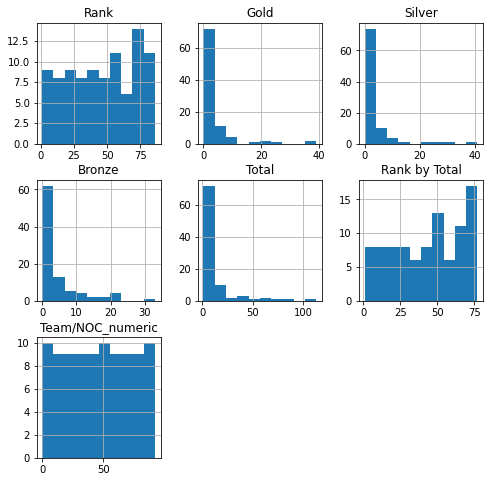

In [31]:
medals_df.hist(figsize=(8,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a6e62d910>,
      dtype=object)

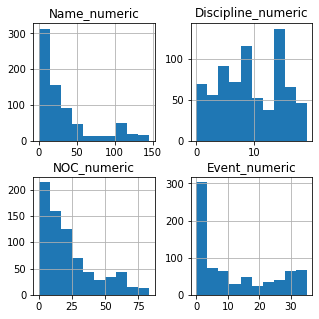

In [32]:
teams_df.hist(figsize=(5,5))

### 1.5 Show Outliers with Boxplot

In [33]:
def show_boxplot(dataframe):
  for column_name in dataframe.keys():
    if dataframe[column_name].dtype != np.object:
      dataframe.boxplot(column=column_name, figsize=(5,5))
      plt.show()

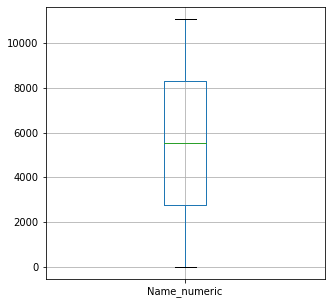

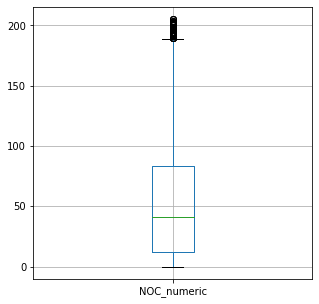

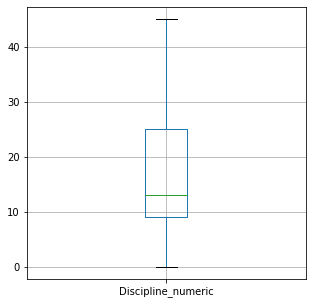

In [34]:
show_boxplot(athletes_df)

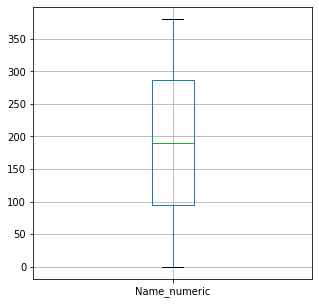

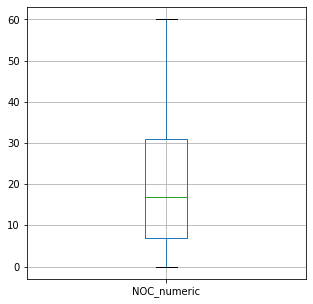

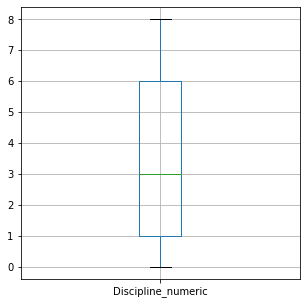

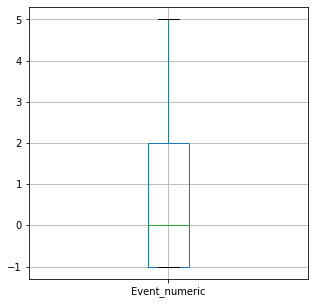

In [35]:
show_boxplot(coaches_df)

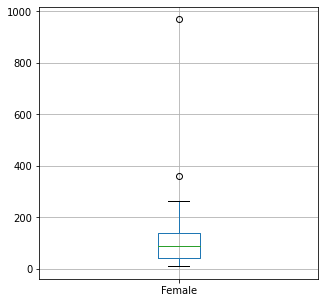

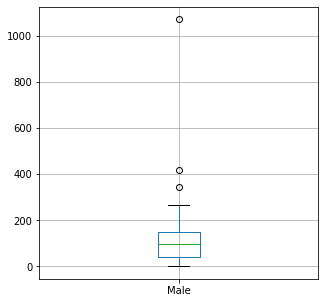

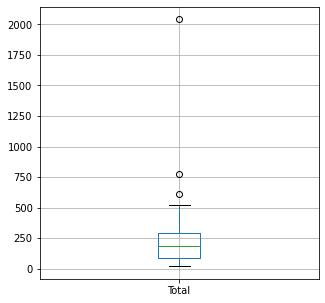

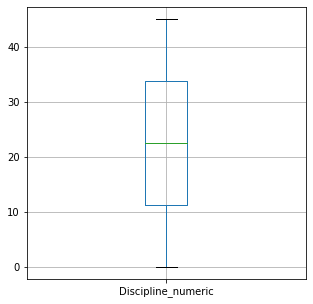

In [36]:
show_boxplot(entries_gender_df)

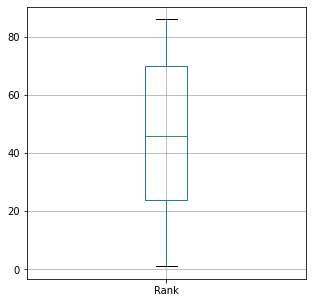

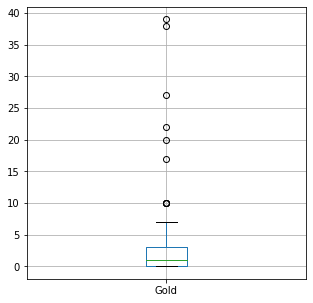

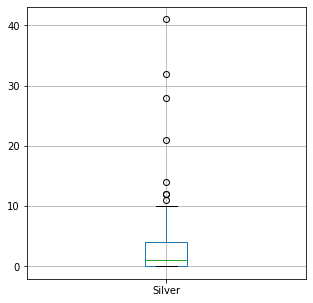

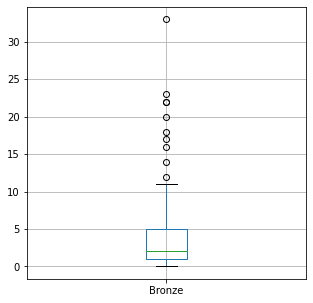

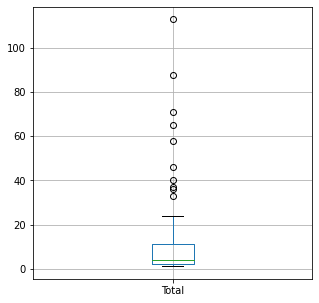

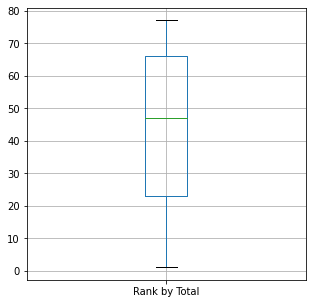

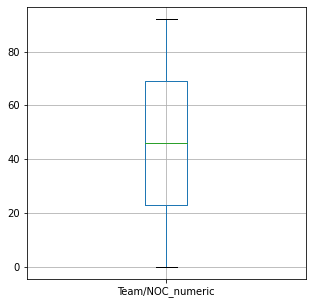

In [37]:
show_boxplot(medals_df)

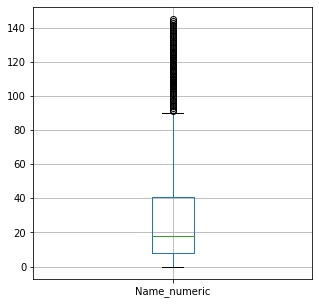

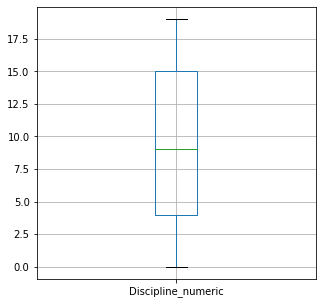

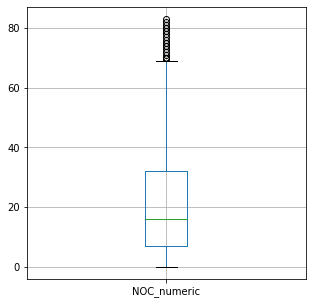

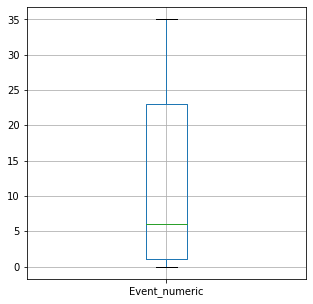

In [38]:
show_boxplot(teams_df)

### 1.6 dissimilarity matrix

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

In [40]:
def dissimilarity_matrix(dataframe):
  for column_name in dataframe.keys():
    if dataframe[column_name].dtype == np.object:
      dataframe = dataframe.drop(column_name, axis=1, inplace=False)
  sim_matrix = cosine_similarity(dataframe.iloc[0:10])
  dissim_matrix = 1 - sim_matrix
  return dissim_matrix

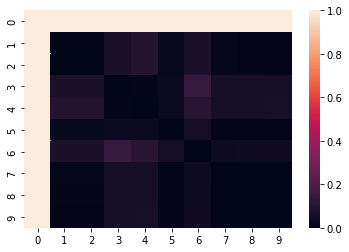

In [41]:
sns.heatmap(dissimilarity_matrix(athletes_df))

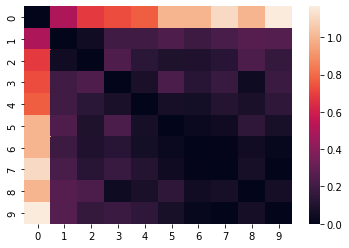

In [42]:
sns.heatmap(dissimilarity_matrix(coaches_df))

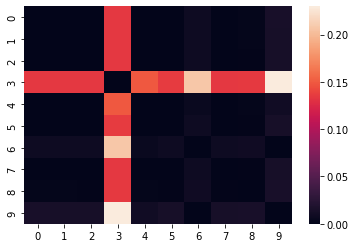

In [43]:
sns.heatmap(dissimilarity_matrix(entries_gender_df))

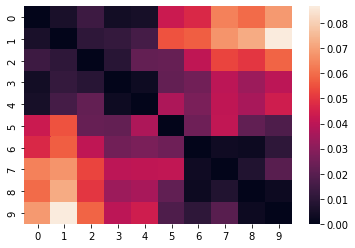

In [44]:
sns.heatmap(dissimilarity_matrix(medals_df))

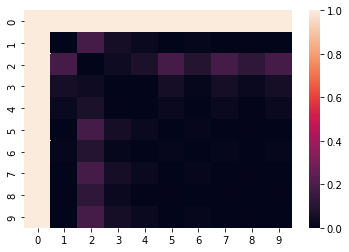

In [45]:
sns.heatmap(dissimilarity_matrix(teams_df))

### 1.8 find correlation of attributes and show scatter plot for them

In [46]:
import seaborn as sns
def show_scatter(dataframe, correlated_attrs):
  for x_column, y_column in correlated_attrs:
    sns.scatterplot(x=x_column, y=y_column, data=dataframe)
    plt.show()

In [47]:
def correlated_attributes(dataframe, threshold=0.95):
  correlated = []
  corr_matrix = dataframe.corr().abs()
  # print(corr_matrix)
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
  for column in upper.columns:
    for index in upper.index:
      if(upper[column][index] > threshold):
        correlated.append([column, index])
  return correlated

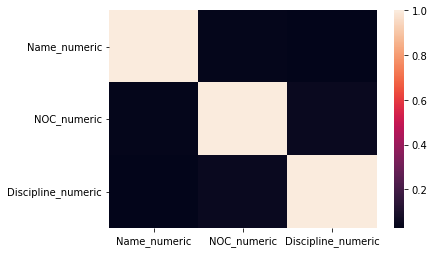

In [48]:
sns.heatmap(athletes_df.corr().abs())

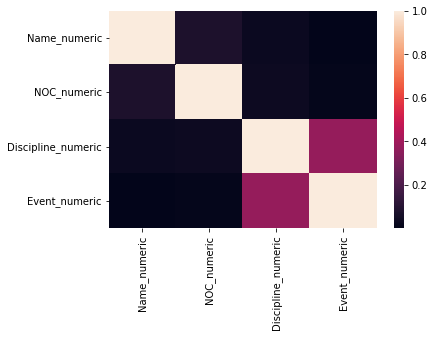

In [49]:
sns.heatmap(coaches_df.corr().abs())

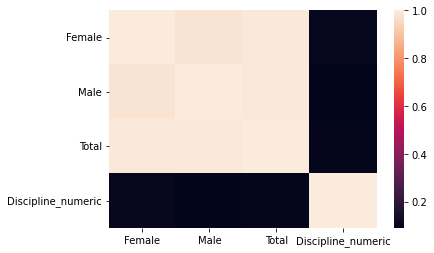

In [50]:
sns.heatmap(entries_gender_df.corr().abs())

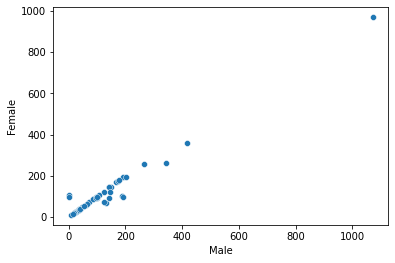

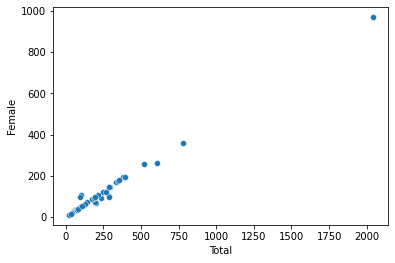

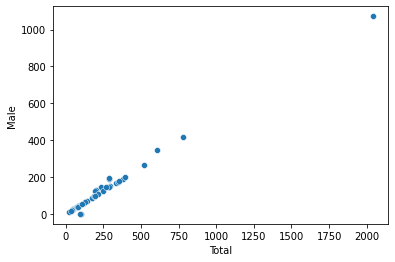

In [51]:
show_scatter(entries_gender_df, correlated_attributes(entries_gender_df))

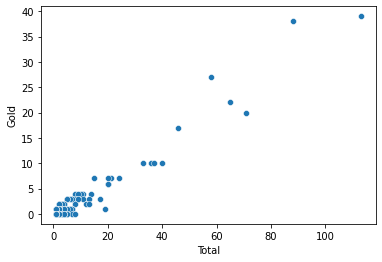

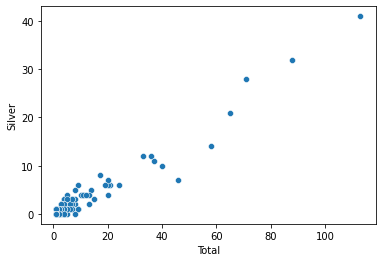

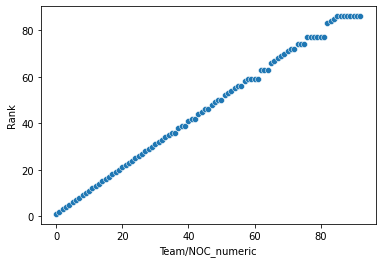

In [52]:
show_scatter(medals_df, correlated_attributes(medals_df))

## 2. Proprocessing Dataset

### 2.1 data cleaning

#### 2.1.1 fill missing values with knn clustering

##### we know that we have missing values in coaches_df["Event"] 
##### and value of missing values in column Event is -1 in column "Event_numeric"

In [53]:
# print(coaches_info["column4_range"])
# print(coaches_df["Event"].mode()[0])
# coaches_df["Event"].fillna(coaches_df["Event"].mode()[0], inplace=True)
# print(coaches_df.info())

In [54]:
# x_test = coaches_df[coaches_df['Event'].isnull()==True]
# x_train = coaches_df[coaches_df['Event'].isnull()==False]
# y_train = x_train['Event_numeric']

# x_train.drop('Event_numeric',axis=1,inplace=True)
# x_train.drop('Event',axis=1,inplace=True)
# x_train.drop('Name',axis=1,inplace=True)
# x_train.drop('NOC',axis=1,inplace=True)
# x_train.drop('Discipline',axis=1,inplace=True)

# x_test.drop('Event_numeric',axis=1,inplace=True)
# x_test.drop('Event',axis=1,inplace=True)
# x_test.drop('Name',axis=1,inplace=True)
# x_test.drop('NOC',axis=1,inplace=True)
# x_test.drop('Discipline',axis=1,inplace=True)

# x_train.head() , x_test.head()

In [55]:
# def normalize(dataframe):
#     result = dataframe.copy()
#     for column_name in dataframe.columns:
#         max_value = dataframe[column_name].max()
#         min_value = dataframe[column_name].min()
#         result[column_name] = (dataframe[column_name] - min_value) / (max_value - min_value)
#     return result
# x_train = normalize(x_train)

In [56]:
# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(y_train)
# print(y_train)
# from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(3)),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.25),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(6, activation='softmax')
# ])
# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=0,
#     patience=20,
#     verbose=0,
#     mode="auto",
#     baseline=None,
#     restore_best_weights=True,
# )
# model.compile(optimizer=tf.keras.optimizers.Adam(), loss = tf.keras.losses.BinaryCrossentropy(from_logits=True))
# model.fit(x_train, y_train,batch_size=16, epochs=500, callbacks=[early_stop], 
#           validation_data=(x_val,y_val))

In [57]:
# plt.plot(model.history.history['loss'])
# plt.plot(model.history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [58]:
# x_test = normalize(x_test)
# y_pred = model.predict(x_test)

In [59]:
coaches_df['Event'].value_counts()

Men         94
Women       88
Duet        27
Softball    20
Team        14
Baseball     6
Name: Event, dtype: int64

In [60]:
coaches_df.loc[coaches_df['Event_numeric'] == -1, 'Event_numeric'] = np.nan
coaches_df.head()

,Name,NOC,Discipline,Event,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric
0,ABDELMAGID Wael,Egypt,Football,NaN,0,0,0,NaN
1,ABE Junya,Japan,Volleyball,NaN,1,1,1,NaN
2,ABE Katsuhiko,Japan,Basketball,NaN,2,1,2,NaN
3,ADAMA Cherif,Côte d'Ivoire,Football,NaN,3,2,0,NaN
4,AGEBA Yuya,Japan,Volleyball,NaN,4,1,1,NaN


In [61]:
coaches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                394 non-null    object 
 1   NOC                 394 non-null    object 
 2   Discipline          394 non-null    object 
 3   Event               249 non-null    object 
 4   Name_numeric        394 non-null    int64  
 5   NOC_numeric         394 non-null    int64  
 6   Discipline_numeric  394 non-null    int64  
 7   Event_numeric       249 non-null    float64
dtypes: float64(1), int64(3), object(4)
memory usage: 24.8+ KB


In [62]:
from sklearn.impute import KNNImputer
coaches_df_copy = coaches_df.copy()
coaches_df_copy.drop('NOC',axis=1,inplace=True)
coaches_df_copy.drop('Event',axis=1,inplace=True)
coaches_df_copy.drop('Name',axis=1,inplace=True)
coaches_df_copy.drop('Discipline',axis=1,inplace=True)

imputer = KNNImputer(n_neighbors=1, weights="uniform")
coaches_df_copy = imputer.fit_transform(coaches_df_copy)

In [63]:
coaches_df['Event'].value_counts(), coaches_df_copy.shape, coaches_df.shape

(Men         94
 Women       88
 Duet        27
 Softball    20
 Team        14
 Baseball     6
 Name: Event, dtype: int64, (394, 4), (394, 8))

In [64]:
coaches_df['Event_numeric'] = coaches_df_copy[:,-1]
coaches_df['Event_numeric'] = coaches_df['Event_numeric'].astype(np.int64)
coaches_df.head()

,Name,NOC,Discipline,Event,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric
0,ABDELMAGID Wael,Egypt,Football,NaN,0,0,0,0
1,ABE Junya,Japan,Volleyball,NaN,1,1,1,0
2,ABE Katsuhiko,Japan,Basketball,NaN,2,1,2,0
3,ADAMA Cherif,Côte d'Ivoire,Football,NaN,3,2,0,0
4,AGEBA Yuya,Japan,Volleyball,NaN,4,1,1,0


In [65]:
coaches_df['Event_numeric'].unique()

array([0, 1, 2, 3, 4, 5])

In [66]:
for i in coaches_df['Event_numeric'].unique():
  coaches_df.loc[(coaches_df['Event'].isnull()) & (coaches_df['Event_numeric'] == i), 'Event'] = (coaches_df[(coaches_df['Event_numeric']==i) & (coaches_df['Event'].isnull()==False)]['Event']).iloc[0]

In [67]:
coaches_df.head()

,Name,NOC,Discipline,Event,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric
0,ABDELMAGID Wael,Egypt,Football,Men,0,0,0,0
1,ABE Junya,Japan,Volleyball,Men,1,1,1,0
2,ABE Katsuhiko,Japan,Basketball,Men,2,1,2,0
3,ADAMA Cherif,Côte d'Ivoire,Football,Men,3,2,0,0
4,AGEBA Yuya,Japan,Volleyball,Men,4,1,1,0


#### 2.1.2 remove outliers with IQR score

###### help link: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

In [68]:
def remove_outliers(dataframe):
  shape_of_df = dataframe.shape
  q1 = dataframe.quantile(0.25)
  q3 = dataframe.quantile(0.75)
  IQR = q3 - q1
  print(IQR)
  dataframe = dataframe[~((dataframe < (q1 - 1.5 * IQR)) |(dataframe > (q3 + 1.5 * IQR))).any(axis=1)]
  print("shape before removing outliers", shape_of_df)
  print("shape after removing outliers", dataframe.shape)
  return dataframe

In [69]:
athletes_df = remove_outliers(athletes_df)
coaches_df = remove_outliers(coaches_df)
medals_df = remove_outliers(medals_df)
entries_gender_df = remove_outliers(entries_gender_df)
teams_df = remove_outliers(teams_df)

Name_numeric          5529.0
NOC_numeric             71.0
Discipline_numeric      16.0
dtype: float64
shape before removing outliers (11085, 6)
shape after removing outliers (11030, 6)
Name_numeric          191.5
NOC_numeric            24.0
Discipline_numeric      5.0
Event_numeric           2.0
dtype: float64
shape before removing outliers (394, 8)
shape after removing outliers (394, 8)
Rank                46.0
Gold                 3.0
Silver               4.0
Bronze               4.0
Total                9.0
Rank by Total       43.0
Team/NOC_numeric    46.0
dtype: float64
shape before removing outliers (93, 8)
shape after removing outliers (82, 8)
Female                 96.00
Male                  109.50
Total                 203.25
Discipline_numeric     22.50
dtype: float64
shape before removing outliers (46, 5)
shape after removing outliers (43, 5)
Name_numeric          33.0
Discipline_numeric    11.0
NOC_numeric           25.0
Event_numeric         22.0
dtype: float64
shape befor

In [70]:
coaches_df.head()
coaches_df.columns

Index(['Name', 'NOC', 'Discipline', 'Event', 'Name_numeric', 'NOC_numeric',
       'Discipline_numeric', 'Event_numeric'],
      dtype='object')

In [71]:
athletes_df.to_csv("athletes_dataframe.csv", index= False)
coaches_df.to_csv("coaches_dataframe.csv", index= False)
entries_gender_df.to_csv("entries_gender_dataframe.csv", index= False)
medals_df.to_csv("medals_dataframe.csv", index= False)
teams_df.to_csv("teams_dataframe.csv", index= False)

### 2.2 Redundancy

#### 2.2.1 find redundancy in columns of datasets

In [72]:
def drop_redundant_columns(dataframe, to_drop):
  # Drop features 
  dataframe.drop(to_drop, axis=1, inplace=True)
  print("columns that are redundant and removed from dataset are:")
  print(to_drop)
  return dataframe

In [73]:
correlated_attributes(athletes_df)

[]

In [74]:
athletes_df = drop_redundant_columns(athletes_df,['Name', 'NOC', 'Discipline'])

columns that are redundant and removed from dataset are:
['Name', 'NOC', 'Discipline']


In [75]:
correlated_attributes(coaches_df)

[]

In [76]:
coaches_df = drop_redundant_columns(coaches_df,['Name', 'NOC', 'Discipline', 'Event'])

columns that are redundant and removed from dataset are:
['Name', 'NOC', 'Discipline', 'Event']


In [77]:
correlated_attributes(entries_gender_df)

[['Total', 'Female'], ['Total', 'Male']]

In [78]:
entries_gender_df = drop_redundant_columns(entries_gender_df,['Total','Discipline'])

columns that are redundant and removed from dataset are:
['Total', 'Discipline']


In [79]:
correlated_attributes(medals_df)

[['Team/NOC_numeric', 'Rank']]

In [80]:
medals_df = drop_redundant_columns(medals_df, ['Rank','Team/NOC'])

columns that are redundant and removed from dataset are:
['Rank', 'Team/NOC']


In [81]:
correlated_attributes(teams_df)

[]

In [82]:
teams_df = drop_redundant_columns(teams_df, ['Name','Discipline','NOC','Event'])

columns that are redundant and removed from dataset are:
['Name', 'Discipline', 'NOC', 'Event']


#### 2.2.2 find redundancy in rows of datasets

In [83]:
def find_redundancy_in_rows(dataframe):
  return dataframe[dataframe.duplicated(keep=False)]

In [84]:
find_redundancy_in_rows(athletes_df)

,Name_numeric,NOC_numeric,Discipline_numeric
253,253,22,4
254,253,22,4


In [85]:
find_redundancy_in_rows(coaches_df)

,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric
143,137,30,4,1
144,137,30,4,1


In [86]:
find_redundancy_in_rows(entries_gender_df)

,Female,Male,Discipline_numeric


In [87]:
find_redundancy_in_rows(medals_df)

,Gold,Silver,Bronze,Total,Rank by Total,Team/NOC_numeric


In [88]:
find_redundancy_in_rows(teams_df)

,Name_numeric,Discipline_numeric,NOC_numeric,Event_numeric


In [89]:
athletes_df.drop_duplicates(keep='first', inplace=True)
coaches_df.drop_duplicates(keep='first', inplace=True)

In [90]:
find_redundancy_in_rows(athletes_df)

,Name_numeric,NOC_numeric,Discipline_numeric


In [91]:
find_redundancy_in_rows(coaches_df)

,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric


### 2.3 Numerosity Reduction

In [92]:
athletes_df.shape, coaches_df.shape, entries_gender_df.shape, medals_df.shape, teams_df.shape

((11029, 3), (393, 4), (43, 3), (82, 6), (644, 4))

In [93]:
athletes_df.head()

,Name_numeric,NOC_numeric,Discipline_numeric
0,0,0,0
1,1,1,1
2,2,2,2
3,3,1,3
4,4,1,3


##### choose best number of clusters

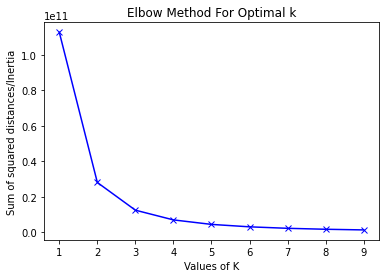

In [94]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(athletes_df)
  Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

##### clustering data and random select from each cluster

In [95]:
km = KMeans(n_clusters=3).fit(athletes_df)
cluster_map = pd.DataFrame()
cluster_map['data_index'] = athletes_df.index.values
cluster_map['cluster'] = km.labels_

In [96]:
cluster_map['cluster'].value_counts()

1    3709
0    3666
2    3654
Name: cluster, dtype: int64

In [97]:
SAMPLES_FROM_EACH_CLUSTER = 2000
samples_index = []
for cluster_label in cluster_map['cluster'].unique():
  x = cluster_map.loc[cluster_map['cluster'] == cluster_label].sample(n = SAMPLES_FROM_EACH_CLUSTER)
  samples_index.extend(x['data_index'].to_numpy().tolist())

In [98]:
athletes_df = athletes_df.loc[samples_index]
athletes_df.reset_index(drop=True, inplace=True)

In [99]:
athletes_df.head()

,Name_numeric,NOC_numeric,Discipline_numeric
0,703,118,3
1,406,111,20
2,802,2,17
3,1025,9,28
4,1183,44,17


### 2.4 Normalization

In [100]:
import pandas as pd
from sklearn import preprocessing
def normalize_with_MinMaxScaler(dataframe):
  x = dataframe.values #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  dataframe = pd.DataFrame(x_scaled, columns=dataframe.keys())
  return dataframe

In [101]:
from scipy import stats
def normalize_with_zscore(dataframe):
  x_scaled = stats.zscore(dataframe)
  return pd.DataFrame(x_scaled, columns=dataframe.keys())

In [102]:
def normalize_with_Normalizer(dataframe):
  normalizer = preprocessing.Normalizer()
  x_scaled = normalizer.fit_transform(dataframe)
  dataframe = pd.DataFrame(x_scaled, columns=dataframe.keys())
  return dataframe

In [103]:
athletes_df.head()

,Name_numeric,NOC_numeric,Discipline_numeric
0,703,118,3
1,406,111,20
2,802,2,17
3,1025,9,28
4,1183,44,17


In [104]:
normalize_with_MinMaxScaler(athletes_df).head()

,Name_numeric,NOC_numeric,Discipline_numeric
0,0.063218,0.624339,0.066667
1,0.036357,0.587302,0.444444
2,0.072171,0.010582,0.377778
3,0.092340,0.047619,0.622222
4,0.106629,0.232804,0.377778


In [105]:
normalize_with_zscore(athletes_df)

,Name_numeric,NOC_numeric,Discipline_numeric
0,-1.511624,1.575544,-1.169555
1,-1.604322,1.412536,0.284406
2,-1.480725,-1.125728,0.027825
3,-1.411123,-0.962720,0.968623
4,-1.361809,-0.147681,0.027825
...,...,...,...
5995,1.376678,-0.217542,0.712042
5996,0.642274,-1.149015,1.139677
5997,0.902889,-0.729852,-0.741919
5998,1.541786,-0.613418,-0.570865


In [106]:
normalize_with_Normalizer(athletes_df)

,Name_numeric,NOC_numeric,Discipline_numeric
0,0.986195,0.165535,0.004209
1,0.963512,0.263423,0.047464
2,0.999772,0.002493,0.021192
3,0.999589,0.008777,0.027306
4,0.999206,0.037164,0.014359
...,...,...,...
5995,0.999988,0.004118,0.002511
5996,0.999992,0.000132,0.003945
5997,0.999997,0.002251,0.000948
5998,0.999997,0.002289,0.000954


In [107]:
normalize_with_Normalizer(athletes_df)

,Name_numeric,NOC_numeric,Discipline_numeric
0,0.986195,0.165535,0.004209
1,0.963512,0.263423,0.047464
2,0.999772,0.002493,0.021192
3,0.999589,0.008777,0.027306
4,0.999206,0.037164,0.014359
...,...,...,...
5995,0.999988,0.004118,0.002511
5996,0.999992,0.000132,0.003945
5997,0.999997,0.002251,0.000948
5998,0.999997,0.002289,0.000954


In [108]:
athletes_norm_df = normalize_with_zscore(athletes_df)
athletes_norm_df.reset_index(drop=True, inplace=True)
coaches_norm_df = normalize_with_zscore(coaches_df)
coaches_norm_df.reset_index(drop=True, inplace=True)
entries_gender_norm_df = normalize_with_zscore(entries_gender_df)
entries_gender_norm_df.reset_index(drop=True, inplace=True)
medals_norm_df = normalize_with_zscore(medals_df)
medals_norm_df.reset_index(drop=True, inplace=True)
teams_norm_df = normalize_with_zscore(teams_df)
teams_norm_df.reset_index(drop=True, inplace=True)

In [109]:
athletes_norm_df.head()

,Name_numeric,NOC_numeric,Discipline_numeric
0,-1.511624,1.575544,-1.169555
1,-1.604322,1.412536,0.284406
2,-1.480725,-1.125728,0.027825
3,-1.411123,-0.962720,0.968623
4,-1.361809,-0.147681,0.027825


In [110]:
coaches_norm_df.head()

,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric
0,-1.727074,-1.270804,-1.341586,-1.065579
1,-1.718002,-1.206212,-0.960078,-1.065579
2,-1.708929,-1.206212,-0.578571,-1.065579
3,-1.699856,-1.141620,-1.341586,-1.065579
4,-1.690783,-1.206212,-0.960078,-1.065579


In [111]:
entries_gender_norm_df.head()

,Female,Male,Discipline_numeric
0,-1.023526,-0.954657,-1.708309
1,-0.451482,-0.463405,-1.632968
2,0.156314,0.058550,-1.557627
3,0.281449,-1.445910,-1.482286
4,-0.058202,-0.110318,-1.331605


In [112]:
medals_norm_df.head()

,Gold,Silver,Bronze,Total,Rank by Total,Team/NOC_numeric
0,2.857927,2.237029,3.458641,3.396121,-1.776803,-1.706174
1,2.857927,2.237029,2.256910,2.836921,-1.729376,-1.664659
2,2.857927,2.237029,1.856333,2.650520,-1.681948,-1.623144
3,2.857927,0.655681,1.055179,1.718519,-1.444810,-1.581629
4,2.322881,2.764145,1.856333,2.650520,-1.681948,-1.540114


In [113]:
teams_norm_df.head()

,Name_numeric,Discipline_numeric,NOC_numeric,Event_numeric
0,-1.086621,-1.608614,-1.219974,-0.980437
1,-1.033684,-1.608614,-1.151165,-0.980437
2,-1.033684,-1.608614,-1.151165,-0.893503
3,-0.980746,-1.608614,-1.082356,-0.893503
4,-0.927808,-1.608614,-1.013546,-0.893503


### 2.5 Dimentionality Reduction

In [114]:
athletes_df.shape, coaches_df.shape, entries_gender_df.shape, medals_df.shape, teams_df.shape

((6000, 3), (393, 4), (43, 3), (82, 6), (644, 4))

In [115]:
def dim_reduction_PCA(dataframe, n_components=2):
  pca = PCA(n_components = n_components)
  x = pca.fit_transform(dataframe)
  x = pd.DataFrame(x)
  return x

In [116]:
athletes_pca_df = dim_reduction_PCA(athletes_df)
coaches_pca_df = dim_reduction_PCA(coaches_df)
entries_gender_pca_df = dim_reduction_PCA(entries_gender_df)
medals_pca_df = dim_reduction_PCA(medals_df)
teams_pca_df = dim_reduction_PCA(teams_df)

In [117]:
athletes_pca_df.shape, coaches_pca_df.shape, entries_gender_pca_df.shape, medals_pca_df.shape, teams_pca_df.shape

((6000, 2), (393, 2), (43, 2), (82, 2), (644, 2))

In [118]:
medals_df.head()

,Gold,Silver,Bronze,Total,Rank by Total,Team/NOC_numeric
10,7,6,11,24,11,10
11,7,6,8,21,12,11
12,7,6,7,20,13,12
13,7,3,5,15,18,13
14,6,7,7,20,13,14


In [119]:
coaches_df['Event_numeric'].value_counts()

0    149
2    141
1     40
3     39
4     16
5      8
Name: Event_numeric, dtype: int64

# 3. models

In [360]:
coaches_for_model = pd.read_csv("coaches_dataframe.csv")
medals_for_model = pd.read_csv("medals_dataframe.csv")
teams_for_model = pd.read_csv("teams_dataframe.csv")
athletes_for_model = pd.read_csv("athletes_dataframe.csv")
entries_gender_for_model = pd.read_csv("entries_gender_dataframe.csv")

In [121]:
coaches_for_model.head()

,Name,NOC,Discipline,Event,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric
0,ABDELMAGID Wael,Egypt,Football,Men,0,0,0,0
1,ABE Junya,Japan,Volleyball,Men,1,1,1,0
2,ABE Katsuhiko,Japan,Basketball,Men,2,1,2,0
3,ADAMA Cherif,Côte d'Ivoire,Football,Men,3,2,0,0
4,AGEBA Yuya,Japan,Volleyball,Men,4,1,1,0


In [122]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
balanced_x, balanced_y = over_sampler.fit_resample(coaches_for_model[['NOC_numeric','Discipline_numeric']], 
                                         coaches_for_model['Event_numeric'])
coaches_for_model['Event_numeric'].value_counts()

0    149
2    141
1     41
3     39
4     16
5      8
Name: Event_numeric, dtype: int64

In [123]:
coaches_for_model['Event'].value_counts()

Men         149
Women       141
Softball     41
Duet         39
Team         16
Baseball      8
Name: Event, dtype: int64

In [124]:
balanced_y.value_counts()

5    149
4    149
3    149
2    149
1    149
0    149
Name: Event_numeric, dtype: int64

In [125]:
balanced_norm_x = normalize_with_zscore(balanced_x)

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(balanced_x, balanced_y, test_size=0.3, random_state=1)
X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(balanced_norm_x, balanced_y, test_size=0.3, random_state=1)

## 3.1 unsupervised 

### 3.1.1 Kmeans model

In [128]:
athletes_for_model.drop(columns=['Name','NOC','Discipline','Name_numeric'], inplace=True)

In [129]:
athletes_for_model = normalize_with_zscore(athletes_for_model)

In [130]:
athletes_for_model.head()

,NOC_numeric,Discipline_numeric
0,-1.161057,-1.426067
1,-1.137914,-1.340287
2,-1.114771,-1.254507
3,-1.137914,-1.168726
4,-1.137914,-1.168726


In [131]:
kmeans_train = athletes_for_model[0:9000]
kmeans_test = athletes_for_model[9000:]

In [132]:
kmeans_train.shape, kmeans_test.shape

((9000, 2), (2030, 2))

In [133]:
# kmeans_Xtrain, kmeans_Xtest, keams_Ytrain, kmeans_Ytest = train_test_split(athletes_for_model, y_data_encoded, test_size=0.2, random_state=40)

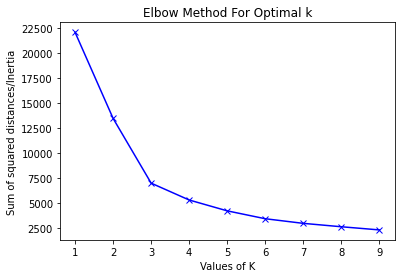

In [134]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(athletes_for_model)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [135]:
kmeans_model = KMeans(n_clusters=3, random_state=0)
label = kmeans_model.fit_predict(athletes_for_model)

In [136]:
athletes_for_model['label'] = label

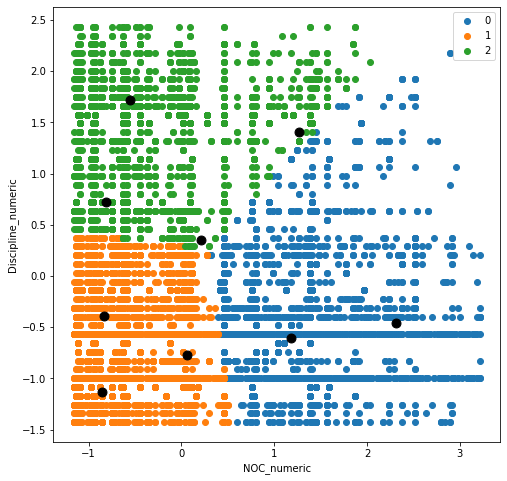

In [137]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
fig = plt.figure(figsize=(8,8))
#plotting the results:
for i in u_labels:
    plt.scatter(athletes_for_model[athletes_for_model['label'] == i]['NOC_numeric'] , 
                athletes_for_model[athletes_for_model['label'] == i]['Discipline_numeric'] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.xlabel("NOC_numeric")
plt.ylabel("Discipline_numeric")
plt.legend()
plt.show()

### 3.1.2 DBScan model

In [138]:
from sklearn.cluster import DBSCAN
dbscan_model = DBSCAN(eps=0.5, min_samples=2).fit(athletes_for_model)

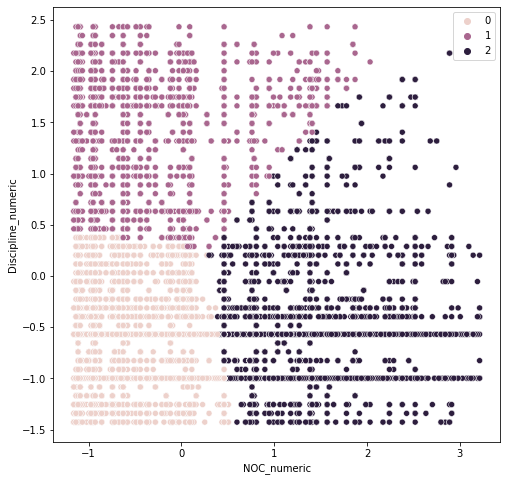

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=athletes_for_model['NOC_numeric'], y=athletes_for_model['Discipline_numeric'], 
                hue=dbscan_model.labels_)
plt.show()

## supervised

### 3.2.1 MLP model

In [200]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
# from tensorflow.python.keras.layers.core import Dropout
from tensorflow.keras.optimizers import Adam, SGD

In [201]:
from tensorflow.keras.utils import to_categorical
y_data_encoded = to_categorical(balanced_y)
x_train_val, x_test2, y_train_val, y_test2 = train_test_split(balanced_x, y_data_encoded, test_size=0.2, random_state=40)
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=40)

In [202]:
x_train2.shape, x_test2.shape, x_val2.shape

((572, 2), (179, 2), (143, 2))

In [242]:
model = tf.keras.Sequential(layers=[Input(shape=(2,)),
                                    Dense(128, activation='relu', name="dense_128"),
                                    Dropout(0.25, name="dropout_1"),
                                    Dense(64, activation='relu', name="dense_64"),
                                    Dropout(0.3, name="dropout_2"),
                                    Dense(32, activation='relu', name="dense_32"),
                                    Dropout(0.15,name="dropout_3"),
                                    Dense(16, activation='relu', name="dense_16"),
                                    Dropout(0.1,name="dropout_4"),
                                    Dense(6, activation='softmax', name="dense_out")
                                    ])
# model.add()
# model.add()
# model.add()
# model.add()
# model.add(Dropout(0.1))
# model.add()
# model.add()
# model.add(Dense(12, activation='relu'))
# model.add()
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_128 (Dense)           (None, 128)               384       
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_64 (Dense)            (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 16)              

In [243]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=25)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [244]:
history = model.fit(x_train2, y_train2, epochs=2000, batch_size=16,validation_data=(x_val2, y_val2), callbacks=[early_stop])

Epoch 1/2000
36/36 [==============================] - 2s 19ms/step - loss: 2.1543 - accuracy: 0.2115 - val_loss: 1.7830 - val_accuracy: 0.2308
Epoch 2/2000
36/36 [==============================] - 0s 6ms/step - loss: 1.9040 - accuracy: 0.1836 - val_loss: 1.7976 - val_accuracy: 0.1329
Epoch 3/2000
36/36 [==============================] - 0s 6ms/step - loss: 1.8922 - accuracy: 0.1731 - val_loss: 1.7794 - val_accuracy: 0.1958
Epoch 4/2000
36/36 [==============================] - 0s 5ms/step - loss: 1.8788 - accuracy: 0.1941 - val_loss: 1.7702 - val_accuracy: 0.2238
Epoch 5/2000
36/36 [==============================] - 0s 9ms/step - loss: 1.8057 - accuracy: 0.2045 - val_loss: 1.7708 - val_accuracy: 0.2657
Epoch 6/2000
36/36 [==============================] - 0s 9ms/step - loss: 1.7900 - accuracy: 0.2220 - val_loss: 1.7610 - val_accuracy: 0.3007
Epoch 7/2000
36/36 [==============================] - 0s 8ms/step - loss: 1.7861 - accuracy: 0.1871 - val_loss: 1.7555 - val_accuracy: 0.3706
Epoch

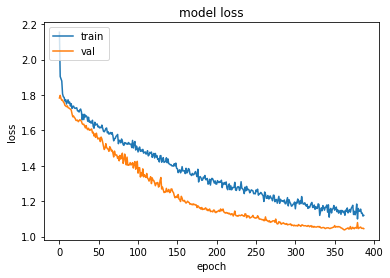

In [245]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [246]:
model.evaluate(x_test2,y_test2)

6/6 [==============================] - 0s 2ms/step - loss: 1.1119 - accuracy: 0.5028


[1.111921787261963, 0.5027933120727539]

In [247]:
model.save('my_model.h5')

### 3.2.2 svm model

In [148]:
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [149]:
def print_confusion_matrix(y_train, y_train_pred, y_test, y_test_pred):
  cm_train = confusion_matrix(y_train, y_train_pred)
  cm_test = confusion_matrix(y_test, y_test_pred)
  print("Training set confusion matrix : \n"+str(cm_train))
  print("Success ratio on training set : "+str(success_ratio(cm=cm_train)))
  print("Test set confusion matrix : \n"+str(cm_test))
  print("Success ratio on test set : "+str(success_ratio(cm=cm_test)))

def success_ratio(cm):
  total = cm[0][0] + cm[1][0] + cm[0][1] + cm[1][1]
  return (cm[0][0] + cm[1][1]) / total

In [150]:
svm_clf = SVC(kernel='linear')
svm_clf = svm_clf.fit(X_train, y_train)

y_test_pred = svm_clf.predict(X_test)
y_train_pred = svm_clf.predict(X_train)
print_confusion_matrix(y_train, y_train_pred, y_test, y_test_pred)

Training set confusion matrix : 
[[25 46  0  7 15 14]
 [ 9 88  0  1  7 13]
 [23 39  0  5 17 14]
 [ 7  3  0 27 54  1]
 [ 4  3  0 10 90  0]
 [ 8 49  0  0  0 46]]
Success ratio on training set : 0.6726190476190477
Test set confusion matrix : 
[[10 21  0  4  4  3]
 [ 1 17  0  2  9  2]
 [ 6 28  0  2 11  4]
 [ 5  3  0 10 35  4]
 [ 2  2  0  4 34  0]
 [ 9 14  0  0  0 23]]
Success ratio on test set : 0.5510204081632653


In [151]:
svm_clf = SVC(kernel='rbf')
svm_clf = svm_clf.fit(X_train, y_train)

y_test_pred = svm_clf.predict(X_test)
y_train_pred = svm_clf.predict(X_train)
print_confusion_matrix(y_train, y_train_pred, y_test, y_test_pred)

Training set confusion matrix : 
[[15 41  4 10 13 24]
 [ 0 88  0  2  6 22]
 [13 36  3  7 14 25]
 [ 2  3  0 44 36  7]
 [ 7  3  0 22 75  0]
 [12 49  0  0  0 42]]
Success ratio on training set : 0.7152777777777778
Test set confusion matrix : 
[[ 8 20  1  4  3  6]
 [ 0 17  0  4  7  3]
 [ 6 23  4  2 11  5]
 [ 3  3  0 17 27  7]
 [ 2  2  0 10 28  0]
 [15 14  0  0  0 17]]
Success ratio on test set : 0.5555555555555556


In [152]:
svm_clf = SVC(kernel='rbf', gamma = 'auto')
svm_clf = svm_clf.fit(X_train, y_train)

y_test_pred = svm_clf.predict(X_test)
y_train_pred = svm_clf.predict(X_train)
print_confusion_matrix(y_train, y_train_pred, y_test, y_test_pred)

Training set confusion matrix : 
[[ 79  13   8   1   4   2]
 [  4  90   0   0   8  16]
 [ 28  13  48   3   5   1]
 [  5   1   5  45  35   1]
 [  0   0   0   0 107   0]
 [  0  15   0   0   0  88]]
Success ratio on training set : 0.9086021505376344
Test set confusion matrix : 
[[22  7 10  1  2  0]
 [ 0 16  0  0 11  4]
 [30  9  7  1  2  2]
 [ 4  0  7 25 19  2]
 [ 0  0  0  0 42  0]
 [ 0  6  0  0  0 40]]
Success ratio on test set : 0.8444444444444444


In [153]:
svm_scores = cross_val_score(svm_clf, balanced_x, balanced_y, cv=10)
k_fold_svm_evaluate = sum(svm_scores)/len(svm_scores)
print("k-fold evaluate for svm model: ",k_fold_svm_evaluate)

k-fold evaluate for svm model:  0.6086267166042447


### 3.2.3 KNN model

In [154]:
from sklearn.neighbors import KNeighborsClassifier

### find optimal value for n_neighbors parameter

#### find n_neghbors in minimum error rate

Minimum error:- 0.4312267657992565 at K = 2


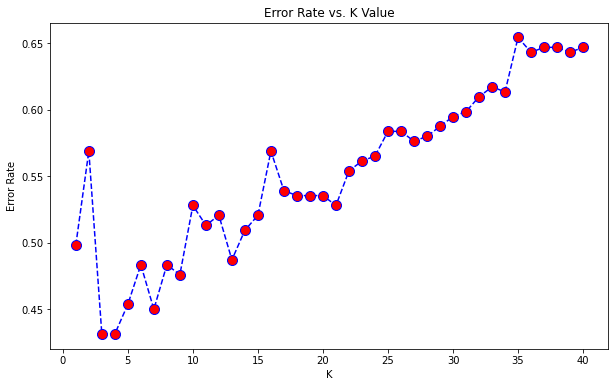

In [155]:
error_rate = []
for i in range(1,41):
  knn_clf = KNeighborsClassifier(n_neighbors=i, p=2).fit(X_norm_train, y_norm_train)
  pred_i = knn_clf.predict(X_norm_test)
  error_rate.append(np.mean(pred_i != y_norm_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,41),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

#### find n_neighbors in maximum accuracy rate

Max accuracy:- 0.6097752808988763 at K = 26


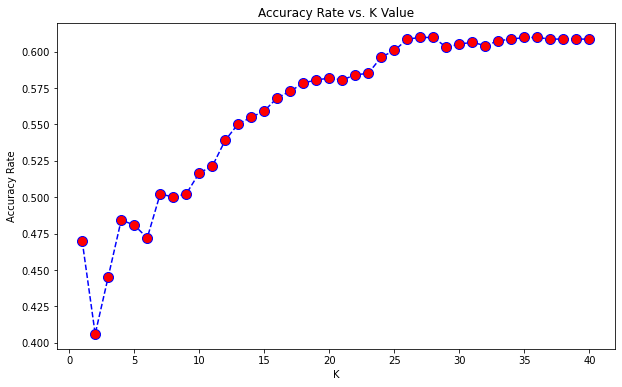

In [156]:
accuracy_rate = []
for i in range(1,41):
  knn_clf = KNeighborsClassifier(n_neighbors=i, weights='distance', p=2)
  # pred_i = knn_clf.predict(X_norm_test)
  k_fold_knn_evaluate = cross_val_score(knn_clf, balanced_norm_x, balanced_y, cv=10)
  accuracy_rate.append(k_fold_knn_evaluate.mean())

plt.figure(figsize=(10,6))
plt.plot(range(1,41),accuracy_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Accuracy Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy Rate')
print("Max accuracy:-",max(accuracy_rate),"at K =",accuracy_rate.index(max(accuracy_rate)))

In [157]:
knn_clf = KNeighborsClassifier(n_neighbors=15,weights='distance', p=2).fit(X_norm_train, y_norm_train)
y_test_pred = knn_clf.predict(X_norm_test)
y_train_pred = knn_clf.predict(X_norm_train)
print_confusion_matrix(y_norm_train, y_train_pred, y_norm_test, y_test_pred)

Training set confusion matrix : 
[[ 81  13   3   4   4   2]
 [  0  79   0   1   8  30]
 [ 26  12  48   6   5   1]
 [  2   0   5  49  35   1]
 [  0   0   0   0 107   0]
 [  0   0   0   0   0 103]]
Success ratio on training set : 0.9248554913294798
Test set confusion matrix : 
[[17  9 12  1  2  1]
 [ 0 13  0  0 11  7]
 [27  8  9  1  4  2]
 [ 4  0  7 25 19  2]
 [ 0  0  0  0 42  0]
 [ 0  0  0  0  0 46]]
Success ratio on test set : 0.7692307692307693


In [241]:
k_fold_knn_evaluate = cross_val_score(knn_clf, balanced_norm_x, balanced_y, cv=10)
print("k-fold evaluate for knn model: %0.2f" % (k_fold_knn_evaluate.mean()))

k-fold evaluate for knn model: 0.56


# 4. frequent patterns and association rules

## 4.1 freq. patterns using apriori

In [361]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [362]:
coaches_for_model.head()

,Name,NOC,Discipline,Event,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric
0,ABDELMAGID Wael,Egypt,Football,Men,0,0,0,0
1,ABE Junya,Japan,Volleyball,Men,1,1,1,0
2,ABE Katsuhiko,Japan,Basketball,Men,2,1,2,0
3,ADAMA Cherif,Côte d'Ivoire,Football,Men,3,2,0,0
4,AGEBA Yuya,Japan,Volleyball,Men,4,1,1,0


In [363]:
medals_for_model.head()

,Rank,Team/NOC,Gold,Silver,Bronze,Total,Rank by Total,Team/NOC_numeric
0,11,Canada,7,6,11,24,11,10
1,12,Brazil,7,6,8,21,12,11
2,13,New Zealand,7,6,7,20,13,12
3,14,Cuba,7,3,5,15,18,13
4,15,Hungary,6,7,7,20,13,14


In [364]:
teams_for_model.head()

,Name,Discipline,NOC,Event,Name_numeric,Discipline_numeric,NOC_numeric,Event_numeric
0,Belgium,3x3 Basketball,Belgium,Men,0,0,0,0
1,China,3x3 Basketball,People's Republic of China,Men,1,0,1,0
2,China,3x3 Basketball,People's Republic of China,Women,1,0,1,1
3,France,3x3 Basketball,France,Women,2,0,2,1
4,Italy,3x3 Basketball,Italy,Women,3,0,3,1


In [365]:
athletes_for_model.head()

,Name,NOC,Discipline,Name_numeric,NOC_numeric,Discipline_numeric
0,AALERUD Katrine,Norway,Cycling Road,0,0,0
1,ABAD Nestor,Spain,Artistic Gymnastics,1,1,1
2,ABAGNALE Giovanni,Italy,Rowing,2,2,2
3,ABALDE Alberto,Spain,Basketball,3,1,3
4,ABALDE Tamara,Spain,Basketball,4,1,3


In [366]:
entries_gender_for_model.head()

,Discipline,Female,Male,Total,Discipline_numeric
0,3x3 Basketball,32,32,64,0
1,Archery,64,64,128,1
2,Artistic Gymnastics,98,98,196,2
3,Artistic Swimming,105,0,105,3
4,Badminton,86,87,173,5


In [367]:
teams_for_fp = teams_for_model.drop(columns=['Name_numeric','Discipline_numeric','NOC_numeric','Event_numeric'])
teams_for_fp['Name'] = teams_for_fp['Name'].str.strip()
teams_for_fp['Discipline'] = teams_for_fp['Discipline'].str.strip()
teams_for_fp['NOC'] = teams_for_fp['NOC'].str.strip()
teams_for_fp['Event'] = teams_for_fp['Event'].str.strip()

In [368]:
coaches_for_fp = coaches_for_model.drop(columns=['Name','Name_numeric','Discipline_numeric','NOC_numeric','Event_numeric'])
# coaches_for_fp['Name'] = coaches_for_fp['Name'].str.strip()
coaches_for_fp['Discipline'] = coaches_for_fp['Discipline'].str.strip()
coaches_for_fp['NOC'] = coaches_for_fp['NOC'].str.strip()
coaches_for_fp['Event'] = coaches_for_fp['Event'].str.strip()

In [369]:
athletes_for_fp = athletes_for_model.drop(columns=['Name','Name_numeric','Discipline_numeric','NOC_numeric'])
# athletes_for_fp['Name'] = athletes_for_fp['Name'].str.strip()
athletes_for_fp['Discipline'] = athletes_for_fp['Discipline'].str.strip()
athletes_for_fp['NOC'] = athletes_for_fp['NOC'].str.strip()

In [370]:
def find_frequent_patterns(dataframe, minsup = 0.1):
  te = TransactionEncoder()
  te_ary = te.fit(dataframe.values.tolist()).transform(dataframe.values.tolist())
  dataframe = pd.DataFrame(te_ary, columns=te.columns_)
  freq_patterns = apriori(dataframe, min_support= minsup, use_colnames=True)
  return freq_patterns

In [371]:
teams_for_fp['NOC'].value_counts()

Japan                       47
United States of America    43
Italy                       37
Germany                     35
Australia                   34
                            ..
Morocco                      1
Kenya                        1
Chile                        1
Malaysia                     1
Republic of Moldova          1
Name: NOC, Length: 61, dtype: int64

In [372]:
teams_for_japan = teams_for_fp[teams_for_fp['NOC'] == 'Japan']
teams_for_usa = teams_for_fp[teams_for_fp['NOC'] == 'United States of America']
teams_for_japan_usa = teams_for_fp[(teams_for_fp['NOC'] == 'Japan') | (teams_for_fp['NOC'] == 'United States of America')]

In [373]:
find_frequent_patterns(teams_for_japan, 0.1)

,support,itemsets
0,0.106383,(Fencing)
1,1.000000,(Japan)
2,0.191489,(Men)
3,0.148936,(Swimming)
4,0.191489,(Women)
5,0.106383,"(Japan, Fencing)"
6,0.191489,"(Men, Japan)"
7,0.148936,"(Japan, Swimming)"
8,0.191489,"(Japan, Women)"


In [374]:
find_frequent_patterns(teams_for_usa, 0.2)

,support,itemsets
0,1.0,(United States)
1,1.0,(United States of America)
2,1.0,"(United States, United States of America)"


In [375]:
find_frequent_patterns(teams_for_japan_usa, 0.2)

,support,itemsets
0,0.522222,(Japan)
1,0.477778,(United States)
2,0.477778,(United States of America)
3,0.477778,"(United States, United States of America)"


In [376]:
coaches_for_fp['NOC'].value_counts()

Japan                       35
Spain                       28
United States of America    28
Australia                   22
Canada                      16
                            ..
Belarus                      1
Bahrain                      1
Cambodia                     1
Liechtenstein                1
Slovakia                     1
Name: NOC, Length: 61, dtype: int64

In [377]:
coaches_for_japan = coaches_for_fp[coaches_for_fp['NOC']=='Japan']
coaches_for_spain = coaches_for_fp[coaches_for_fp['NOC']=='Spain']
coaches_for_japan_spain = coaches_for_fp[(coaches_for_fp['NOC']=='Japan') | (coaches_for_fp['NOC']=='Spain')]

In [378]:
find_frequent_patterns(coaches_for_japan,0.4)

,support,itemsets
0,1.000000,(Japan)
1,0.428571,(Men)
2,0.400000,(Women)
3,0.428571,"(Men, Japan)"
4,0.400000,"(Japan, Women)"


In [381]:
find_frequent_patterns(coaches_for_spain, 0.3)

,support,itemsets
0,0.357143,(Basketball)
1,0.357143,(Men)
2,1.000000,(Spain)
3,0.357143,(Women)
4,0.357143,"(Basketball, Spain)"
5,0.357143,"(Men, Spain)"
6,0.357143,"(Women, Spain)"


In [383]:
find_frequent_patterns(coaches_for_japan_spain,0.3)

,support,itemsets
0,0.555556,(Japan)
1,0.396825,(Men)
2,0.444444,(Spain)
3,0.380952,(Women)


In [337]:
athletes_for_fp['NOC'].value_counts()

United States of America      615
Japan                         586
Australia                     470
People's Republic of China    401
Germany                       400
                             ... 
Bermuda                         2
Andorra                         2
Marshall Islands                2
Mauritania                      2
Vanuatu                         2
Name: NOC, Length: 190, dtype: int64

In [338]:
athletes_for_fp_usa = athletes_for_fp[athletes_for_fp['NOC']=='United States of America']
athletes_for_fp_japan = athletes_for_fp[athletes_for_fp['NOC']=='Japan']
athletes_for_fp_australia = athletes_for_fp[athletes_for_fp['NOC']=='Australia']

In [384]:
find_frequent_patterns(athletes_for_fp_usa, 0.2)

,support,itemsets
0,0.234146,(Athletics)
1,1.000000,(United States of America)
2,0.234146,"(Athletics, United States of America)"


In [385]:
find_frequent_patterns(athletes_for_fp_japan, 0.1)

,support,itemsets
0,0.119454,(Athletics)
1,1.000000,(Japan)
2,0.119454,"(Japan, Athletics)"


In [386]:
find_frequent_patterns(athletes_for_fp_australia, 0.1)

,support,itemsets
0,0.138298,(Athletics)
1,1.000000,(Australia)
2,0.138298,"(Australia, Athletics)"
